<a href="https://colab.research.google.com/github/sashank1079/prediction-flight-delays/blob/main/Predict_Delay_in_Flight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
!pip install catboost

from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.exceptions import DataConversionWarning

import warnings
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)

     |████████████████████████████████| 76.3 MB 1.3 MB/s 


In [ ]:
data = pd.read_csv('data.csv')

### Data Format
Instead of picking up dataset directly from Kaggle, I preferred to get the data from the website of [US Bureau of Transportation Statistics](https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236) for the month of February 2020.
After carefully analyzing each data points, I decided to manually pick 9 variable to predict if there will be a delay in the flight.
- __MONTH__ - Month
- __DAY_OF_MONTH__ - Day of Month
- __DAY_OF_WEEK__ - Day of Week
- __OP_UNIQUE_CARRIER__ - Unique Carrier Code
- __ORIGIN__ - Origin airport location
- __DEST__ - Destination airport location
- __DEP_TIME__ - Actual Departure Time (local time: hhmm)
- __DEP_DEL15__ - Departure Delay Indicator, 15 Minutes or More (1=Yes, 0=No) [TARGET VARIABLE]
- __DISTANCE__ - Distance between airports (miles)

In [ ]:
data.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,DEST,DEP_TIME,DEP_DEL15,DISTANCE,Unnamed: 9
0,2,1,6,MQ,CLT,LYH,1430.0,0.0,175.0,NaN
1,2,8,6,MQ,CLT,LYH,1442.0,0.0,175.0,NaN
2,2,13,4,MQ,DFW,SHV,2247.0,0.0,190.0,NaN
3,2,14,5,MQ,DFW,SHV,2230.0,0.0,190.0,NaN
4,2,15,6,MQ,DFW,SHV,2246.0,0.0,190.0,NaN


## Data Preprocessing

In [ ]:
data = data.drop(['Unnamed: 9'], axis=1)

In [ ]:
data['DEP_DEL15'].value_counts()

0.0    487135
1.0     82182
Name: DEP_DEL15, dtype: int64

In [ ]:
# Split the data into positive and negative
positive_rows = data.DEP_DEL15 == 1.0
data_pos = data.loc[positive_rows]
data_neg = data.loc[~positive_rows]

# Merge the balanced data
data = pd.concat([data_pos, data_neg.sample(n = len(data_pos))], axis = 0)

# Shuffle the order of data
data = data.sample(n = len(data)).reset_index(drop = True)

In [ ]:
data.isna().sum()

MONTH                  0
DAY_OF_MONTH           0
DAY_OF_WEEK            0
OP_UNIQUE_CARRIER      0
ORIGIN                 0
DEST                   0
DEP_TIME             826
DEP_DEL15            828
DISTANCE               0
dtype: int64

In [ ]:
data = data.dropna(axis=0)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163536 entries, 0 to 164363
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   MONTH              163536 non-null  int64  
 1   DAY_OF_MONTH       163536 non-null  int64  
 2   DAY_OF_WEEK        163536 non-null  int64  
 3   OP_UNIQUE_CARRIER  163536 non-null  object 
 4   ORIGIN             163536 non-null  object 
 5   DEST               163536 non-null  object 
 6   DEP_TIME           163536 non-null  float64
 7   DEP_DEL15          163536 non-null  float64
 8   DISTANCE           163536 non-null  float64
dtypes: float64(3), int64(3), object(3)
memory usage: 12.5+ MB


In [ ]:
data['DEP_DEL15'] = data['DEP_DEL15'].astype(int)

In [ ]:
data.shape

(163536, 9)

## Exploratory Data Analysis

In [ ]:
data.describe()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,DEP_TIME,DEP_DEL15,DISTANCE
count,163536.0,163536.000000,163536.000000,163536.000000,163536.000000,163536.000000
mean,2.0,14.800240,4.023273,1416.901386,0.502532,792.925662
std,0.0,8.179284,1.920408,497.580345,0.499995,574.918579
min,2.0,1.000000,1.000000,1.000000,0.000000,31.000000
25%,2.0,7.000000,2.000000,1026.000000,0.000000,370.000000
50%,2.0,14.000000,4.000000,1437.000000,1.000000,644.000000
75%,2.0,22.000000,6.000000,1826.000000,1.000000,1034.000000
max,2.0,29.000000,7.000000,2400.000000,1.000000,5095.000000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


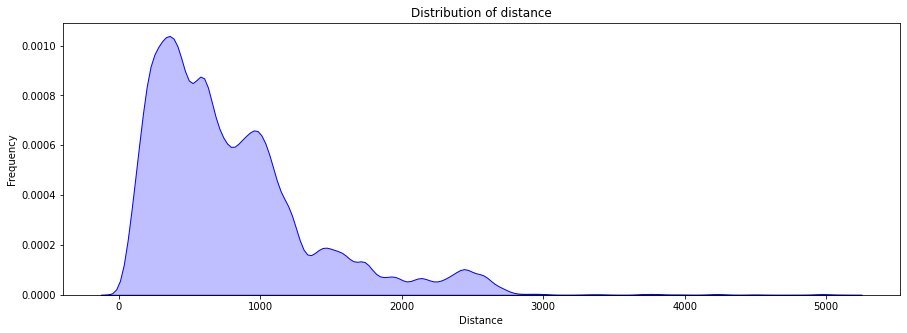

In [ ]:
plt.figure(figsize=(15,5))
sns.distplot(data['DISTANCE'], hist=False, color="b", kde_kws={"shade": True})
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.title("Distribution of distance")
plt.show()

In [ ]:
print(f"Average distance if there is a delay {data[data['DEP_DEL15'] == 1]['DISTANCE'].values.mean()} miles")
print(f"Average distance if there is no delay {data[data['DEP_DEL15'] == 0]['DISTANCE'].values.mean()} miles")

Average distance if there is a delay 786.1071280815751 miles
Average distance if there is no delay 799.8135924478206 miles


### Count of carriers in the dataset

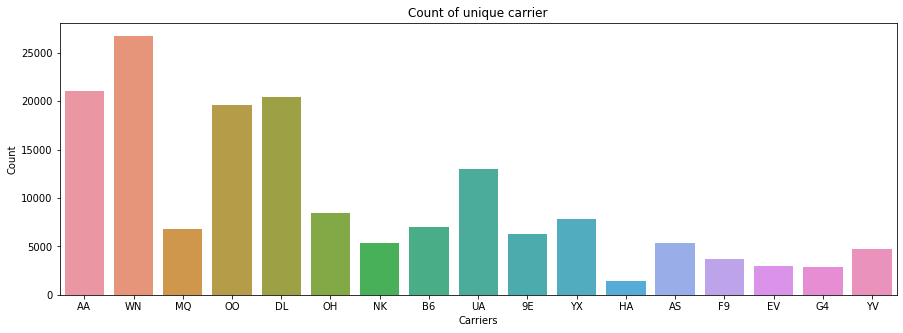

In [ ]:
plt.figure(figsize=(15,5))
sns.countplot(x=data['OP_UNIQUE_CARRIER'], data=data)
plt.xlabel("Carriers")
plt.ylabel("Count")
plt.title("Count of unique carrier")
plt.show()

### Count of origin and destination airport

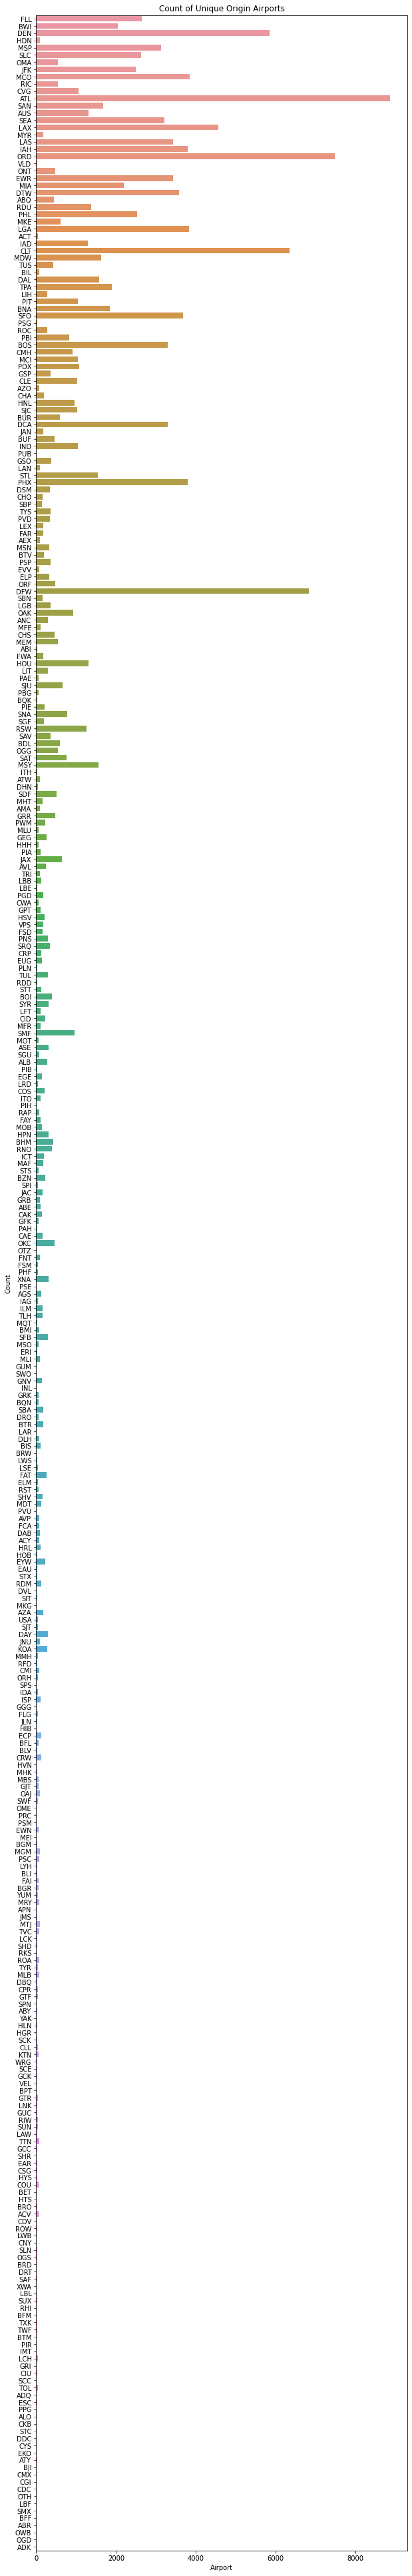

In [ ]:
plt.figure(figsize=(10,70))
sns.countplot(y=data['ORIGIN'], data=data, orient="h")
plt.xlabel("Airport")
plt.ylabel("Count")
plt.title("Count of Unique Origin Airports")
plt.show()

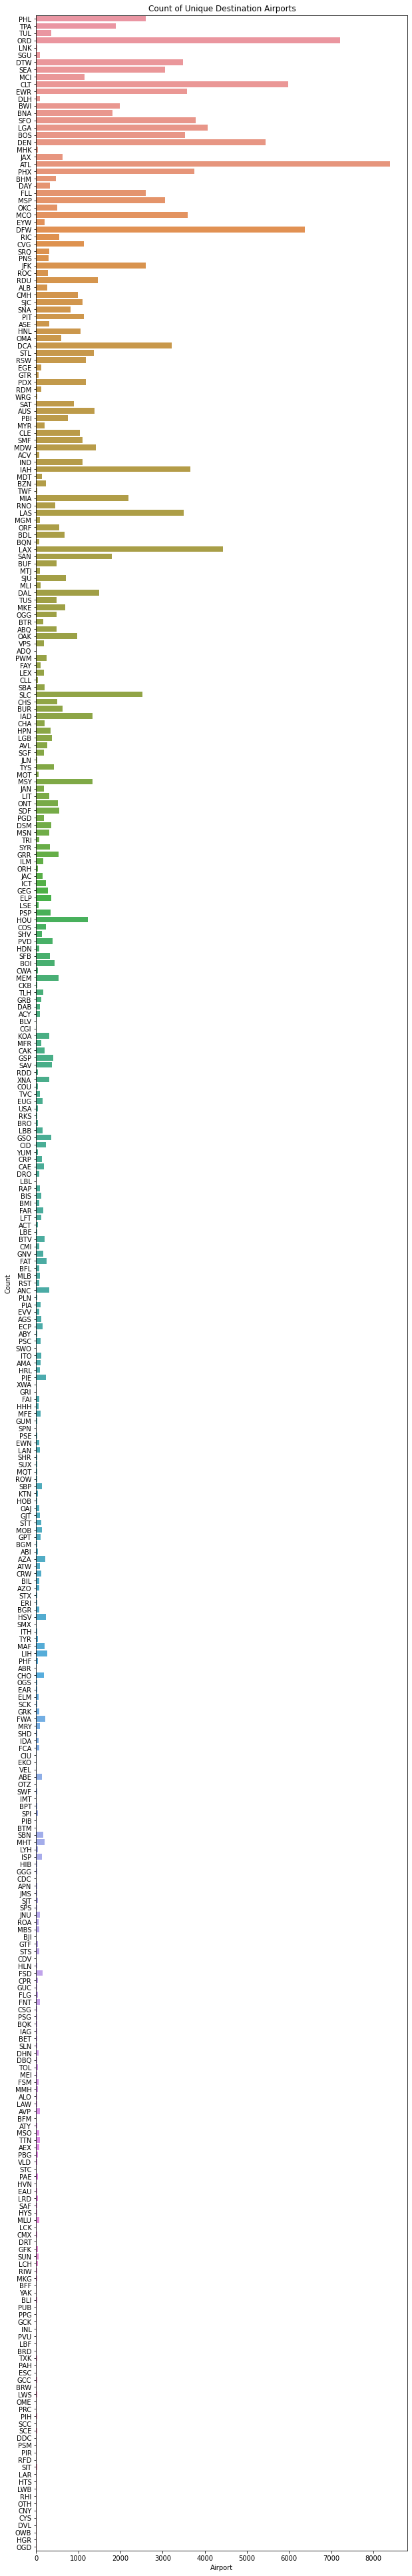

In [ ]:
plt.figure(figsize=(10,70))
sns.countplot(y=data['DEST'], data=data, orient="h")
plt.xlabel("Airport")
plt.ylabel("Count")
plt.title("Count of Unique Destination Airports")
plt.show()

## Modelling


In [ ]:
data = data.rename(columns={'DEP_DEL15':'TARGET'})

__Encoding the categorical variable__

In [ ]:
def label_encoding(categories):
    #To perform mapping of categorical features
    categories = list(set(list(categories.values)))
    mapping = {}
    for idx in range(len(categories)):
        mapping[categories[idx]] = idx
    return mapping

In [ ]:
data['OP_UNIQUE_CARRIER'] = data['OP_UNIQUE_CARRIER'].map(label_encoding(data['OP_UNIQUE_CARRIER']))

In [ ]:
data['ORIGIN'] = data['ORIGIN'].map(label_encoding(data['ORIGIN']))

In [ ]:
data['DEST'] = data['DEST'].map(label_encoding(data['DEST']))

In [ ]:
data.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,DEST,DEP_TIME,TARGET,DISTANCE
0,2,6,4,0,234,279,1812.0,1,992.0
1,2,4,2,16,273,175,1555.0,0,842.0
2,2,13,4,16,327,232,1928.0,0,541.0
3,2,16,7,14,310,295,1329.0,1,1009.0
4,2,9,7,6,339,41,1703.0,1,331.0


In [ ]:
data['TARGET'].value_counts()

1    82182
0    81354
Name: TARGET, dtype: int64

In [ ]:
X = data.drop(['MONTH','TARGET'], axis=1)
y = data[['TARGET']].values

In [ ]:
# Splitting Train-set and Test-set
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=41)

# Splitting Train-set and Validation-set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=41)

### Choosing the evaluation metric

In [ ]:
# Formula to get accuracy
def get_accuracy(y_true, y_preds):
    # Getting score of confusion matrix
    true_negative, false_positive, false_negative, true_positive = confusion_matrix(y_true, y_preds).ravel()
    # Calculating accuracy
    accuracy = (true_positive + true_negative)/(true_negative + false_positive + false_negative + true_positive)
    return accuracy

### Creating some baseline models

__Logistic Regression__

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=0).fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


__CatboostClassifier__

In [ ]:
# Initialize CatBoostClassifier
catboost = CatBoostClassifier(random_state=0)
catboost.fit(X_train, y_train, verbose=False)

__Naive Bayes__

In [ ]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

__Random Forest Classifier__

In [ ]:
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

__KNN Classifier__

In [ ]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=2)

### Evaluation of accuracy on validation dataset

In [ ]:
models = [lr, catboost, gnb, rf, knn]
acc = []
for model in models:
    preds_val = model.predict(X_val)
    accuracy = get_accuracy(y_val, preds_val)
    acc.append(accuracy)

In [ ]:
model_name = ['Logistic Regression', 'Catboost', 'Naive Bayes', 'Random Forest', 'KNN']
accuracy = dict(zip(model_name, acc))

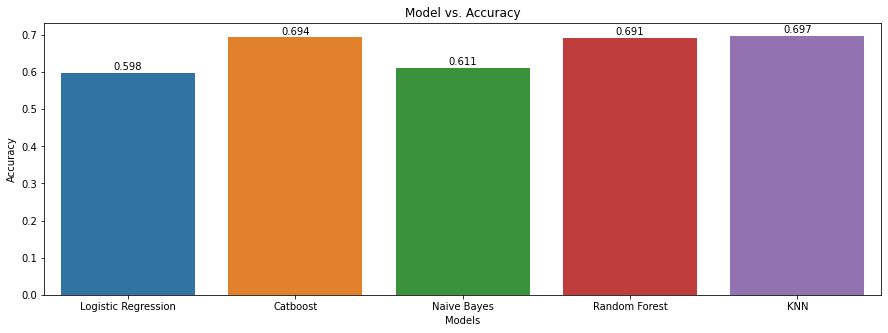

In [ ]:
plt.figure(figsize=(15,5))
ax = sns.barplot(x = list(accuracy.keys()), y = list(accuracy.values()))
for p, value in zip(ax.patches, list(accuracy.values())):
    _x = p.get_x() + p.get_width() / 2
    _y = p.get_y() + p.get_height() + 0.008
    ax.text(_x, _y, round(value, 3), ha="center")
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model vs. Accuracy")
plt.show()